## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
!pip install scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.23.5 pandas==2.0.3 \
             keras-tuner==1.3.5 opencv-python opencv-contrib-python -q --user

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math, random

import cv2
import PIL
from PIL import Image

# Keras Sequential Model
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

# Importing all the different layers and optimizers
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
)
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
# from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
from keras.applications.vgg16 import VGG16

from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    train_test_split, 
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder


# The below code can be used to ignore the warnings that may occur due to deprecations
import warnings
warnings.filterwarnings("ignore")
tf.config.run_functions_eagerly(True)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading the dataset

In [4]:
# Loading BRG images for numpy array file
imageData = np.load('images.npy')
# loading the target labels
imageLabel = pd.read_csv('Labels.csv')

In [5]:
# Making copies
imgData = imageData.copy()
imgLabel = imageLabel.copy()
# Separate target variable
y_label = imgLabel['Label']

## Data Overview

### Understand the shape of the dataset

In [6]:
# There are 4750 color images size 128x128 with 3 channels (RGB)
imgData.shape

(4750, 128, 128, 3)

In [7]:
# Display first 5 target labels
y_label.head()

0    Small-flowered Cranesbill
1    Small-flowered Cranesbill
2    Small-flowered Cranesbill
3    Small-flowered Cranesbill
4    Small-flowered Cranesbill
Name: Label, dtype: object

In [8]:
# Confirming its shape
y_label.shape

(4750,)

In [9]:
# Create a list of 12 classes 
cat_labels=np.unique(y_label) 
cat_labels

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

### Data Visualization

In [10]:
# function to display images
def display_images(data, target):
    num_classes=target.nunique()                                                    # Number of Classes
                                                                                    # Obtaing the unique classes from label
    rows = 1
    cols = 4                                                                        # Defining number of rows=1 and cols=4
    fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
    for i in range(rows):
        for j in range(cols):
            random_index = np.random.randint(0, len(target))                         # Generating random indices from the data and plotting the images
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)                       # Adding subplots with 1 rows and 4 columns
            ax.imshow(data[random_index, :], cmap=plt.get_cmap('gray'))              # Plotting the image using cmap=gray
            ax.set_title(target[random_index])                                       # Plotting the plant's name
            plt.subplots_adjust(wspace=0.3, hspace=0.5)                              # Adding some spaces between images
    plt.show()

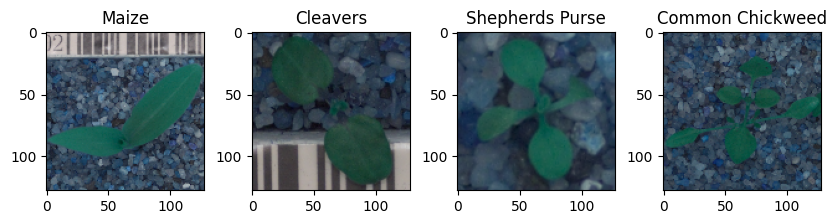

In [11]:
# Display BGR images
display_images(imgData, y_label)

---
- The images of the young seedlings are in BGR format with top-down view.  
- Some images contain small pebbles and a ruler for measurement. 
---

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

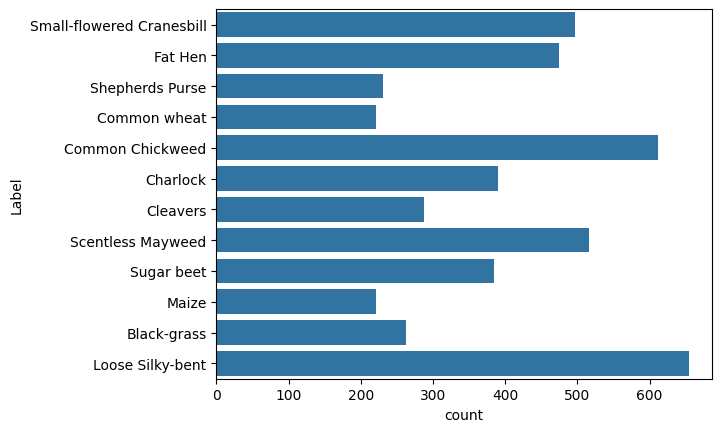

In [12]:
# Plot distribution of each category 
count_plot = sns.countplot(y_label)

---
- The good thing about the images of the young seedlings is that their leaves are all green.
- The background of the images is unique with pebble stones and a measuring ruler.
- The bad thing about them is that their shapes are somehow similar maybe because of their early growth stages. 
- The dataset is imbalanced.  The categories of Shepherds Purse, Common Wheat, and Maize have the least observations.
- Loose Silky-bent category has the most representation. 
---

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [13]:
# 1st option: conversion with cv2
# for i in range(len(imgData)):
#    imgData[i] = cv2.cvtColor(imgData[i], cv2.COLOR_BGR2RGB) 

# 2nd option: reversing B & R channels
# imgData = imgData[:,:,:,::-1]

### Create 3 datasets of images: Resized RGB, Segmented, and Laplacian edge detection images. 

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [14]:
# Functions for segmentation
def create_mask(image):
    
    lower_hsv = np.array([25, 100, 50])
    upper_hsv = np.array([95, 255, 255])
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))  
    
    hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # COLOR_BGR2HSV
    mask = cv2.inRange(hsv_img, lower_hsv, upper_hsv)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
    
def sharp_image(image):
    blur_img = cv2.GaussianBlur(image, (0, 0), 3)
    sharp_img = cv2.addWeighted(image, 1.5, blur_img, -0.5, 0)
    return sharp_img
    
def segment(image):
    mask = create_mask(image)
    masking = cv2.bitwise_and(image, image, mask = mask)
    sharp_img = sharp_image(masking)
    return sharp_img

def edge_detection(image):
    gs_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)     
    lap_image = cv2.Laplacian(gs_image*255, cv2.CV_64F)    
    abs_laplacian = cv2.convertScaleAbs(lap_image)
    laplacian_normalized = cv2.normalize(abs_laplacian, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    laplacian_rgb = cv2.cvtColor(laplacian_normalized, cv2.COLOR_GRAY2RGB)  #=COLOR_GRAY2BGR  
    return laplacian_rgb
    

In [15]:
# Transform data with or loop
rgb_list = []
segmented_list = []

for image in imgData:
    resized_image = cv2.resize(image, (64,64), interpolation=cv2.INTER_LINEAR)
    
    gb_image = cv2.GaussianBlur(resized_image, ksize=(3,3), sigmaX=0)
    rgb_image = cv2.cvtColor(gb_image, cv2.COLOR_BGR2RGB)     
    rgb_list.append(rgb_image)
    
    segmented_image = segment(rgb_image) 
    segmented_list.append(segmented_image)

In [16]:
# Save lists to arrays

In [17]:
rgb_image = np.array(rgb_list)
rgb_image.shape

(4750, 64, 64, 3)

In [18]:
segmented_image = np.array(segmented_list)
segmented_image.shape

(4750, 64, 64, 3)

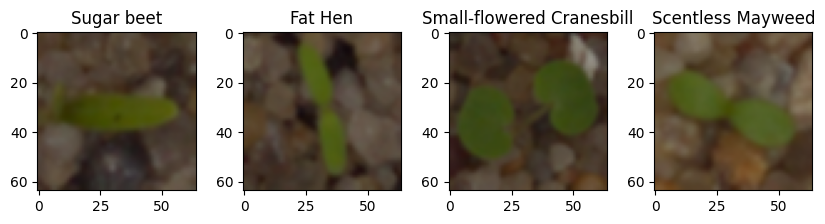

In [19]:
# Display RGB images
display_images(rgb_image, y_label)

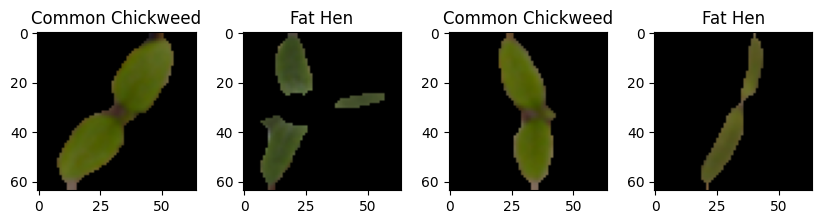

In [20]:
# Display segmented images
display_images(segmented_image, y_label)

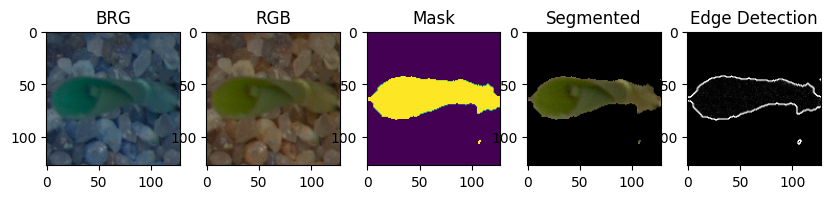

In [21]:
# Compare segmented images 
img_test = imgData[y_label == "Maize"][10]
fig, axs = plt.subplots(1, 5, figsize=(10, 8))
axs[0].imshow(img_test)
axs[0].set_title("BRG")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB) 
axs[1].imshow(img_test)
axs[1].set_title("RGB")
axs[2].imshow(create_mask(img_test))
axs[2].set_title("Mask")
axs[3].imshow(segment(img_test))
axs[3].set_title("Segmented")
axs[4].imshow(edge_detection(segment(img_test)))
axs[4].set_title("Edge Detection");

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

#### Split the 1st dataset

In [22]:
# 1st dataset RGB images with gaussian blur
X = rgb_image
y = y_label

In [23]:
# Splitting the dataset into the Training, Validation, and Test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [24]:
# Display shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(3040, 64, 64, 3) (3040,)
(760, 64, 64, 3) (760,)
(950, 64, 64, 3) (950,)


##### Encode the target labels

In [25]:
# Encoding the target variable to numbers 1 to 12 as the target index.  Note: sparse_categorical_crossentropy. 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

In [26]:
# Display shapes of target variables
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3040,)
(760,)
(950,)


##### Data Normalization

In [27]:
# Min & Max values of the independent variable
print(X_train.max(), X_val.max(), X_test.max())
print(X_train.min(), X_val.min(), X_test.min())

254 235 254
0 0 0


In [28]:
X_train, X_val, X_test = X_train.astype('float32')/(255), X_val.astype('float32')/(255), X_test.astype('float32')/(255)

In [29]:
# Min & Max values of the independent variable after scaling
print(X_train.max(), X_val.max(), X_test.max())
print(X_train.min(), X_val.min(), X_test.min())

0.99607843 0.92156863 0.99607843
0.0 0.0 0.0


#### Split the segmented 2nd dataset 

In [30]:
# 2nd dataset segmented images
X_seg = segmented_image
y_seg = y_label

In [31]:
# Splitting the dataset into the Training, Validation, and Test set.
X_seg_train, X_seg_test, y_seg_train, y_seg_test = train_test_split(X_seg, y_seg, test_size=0.2, random_state=42, stratify=y_seg)
X_seg_train, X_seg_val, y_seg_train, y_seg_val = train_test_split(X_seg_train, y_seg_train, test_size=0.2, random_state=42, stratify=y_seg_train)

In [32]:
# Display shapes
print(X_seg_train.shape, y_seg_train.shape)
print(X_seg_val.shape, y_seg_val.shape)
print(X_seg_test.shape, y_seg_test.shape)

(3040, 64, 64, 3) (3040,)
(760, 64, 64, 3) (760,)
(950, 64, 64, 3) (950,)


##### Encode the target labels

In [33]:
# Encoding the target variable to numbers 1 to 12 as the target index.  Note: sparse_categorical_crossentropy. 
encoder = LabelEncoder()
y_seg_train = encoder.fit_transform(y_seg_train)
y_seg_val = encoder.transform(y_seg_val)
y_seg_test = encoder.transform(y_seg_test)

In [34]:
# Display shapes of target variables
print(y_seg_train.shape)
print(y_seg_val.shape)
print(y_seg_test.shape)

(3040,)
(760,)
(950,)


##### Data Normalization

In [35]:
# Min & Max values of the independent variable
print(X_seg_train.max(), X_seg_val.max(), X_seg_test.max())
print(X_seg_train.min(), X_seg_val.min(), X_seg_test.min())

255 255 255
0 0 0


In [36]:
X_seg_train, X_seg_val, X_seg_test = X_seg_train.astype('float32')/(255), X_seg_val.astype('float32')/(255), X_seg_test.astype('float32')/(255)

In [37]:
# Min & Max values of the independent variable after scaling
print(X_seg_train.max(), X_seg_val.max(), X_seg_train.max())
print(X_seg_train.min(), X_seg_val.min(), X_seg_train.min())

1.0 1.0 1.0
0.0 0.0 0.0


## Model Building

In [38]:
# function to plot the loss and accuracy values
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [39]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    '''
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    '''

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            'Accuracy': acc,
            'Recall': recall,
            'Precision': precision,
            'F1': f1

        },
        index=[0],
    )

    return df_perf

In [40]:
# Function to plot Confusion matrix for array images
def confusion_matrix(model, predictors, target):
    y_pred = model.predict(predictors)
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = target

    cm = tf.math.confusion_matrix(y_test_arg, y_pred_arg)   
    cm = cm.numpy()
    
    f, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, annot=True, linewidths=0.4, fmt='', square=True, ax=ax)    
    ticks = np.arange(len(cat_labels))
    plt.xticks(ticks, cat_labels, rotation=90)
    plt.yticks(ticks, cat_labels, rotation=0)  

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')    
    
    plt.xlabel('Predicted label')    
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show  

In [41]:
# Another option to extract predictions and labels for confusion matrix
# prediction = np.array([])
# target =  np.array([])
# for x, y in normalized_test_ds:
#   prediction = np.concatenate([prediction, np.argmax(VGG_model.predict(x), axis = 1)])
#   target = np.concatenate([target, y])

In [42]:
# function to display confusion matrix for Tensorflow dataset
def confusion_matrix_tf(mod, ds):

    target = np.concatenate([y for x, y in ds], axis=0) 
    prediction = np.argmax(mod.predict(ds),axis=1)

    
    cm = tf.math.confusion_matrix(target, prediction).numpy()
    
    f, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(cm, annot=True, linewidths=0.4, fmt='', square=True, ax=ax)    
    ticks = np.arange(len(cat_labels))
    plt.xticks(ticks, cat_labels, rotation=90)
    plt.yticks(ticks, cat_labels, rotation=0)  

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')    
    
    plt.xlabel('Predicted label')    
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show  

In [43]:
# clears the current Keras session & seed
def reset_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

In [44]:
# function for custom callbacks 
def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     else:
         return lr * math.exp(-0.1)

In [45]:
# class to enable 'start_from_epoch' callback, only necessary because of the downgraded python 3.10 for Gpu usgage.
class CustomEarlyStopping(keras.callbacks.Callback):
   def __init__(self, monitor='val_loss', patience=0, start_from_epoch=0, verbose=0):
       super(CustomEarlyStopping, self).__init__()
       self.monitor = monitor
       self.patience = patience
       self.start_from_epoch = start_from_epoch
       self.verbose = verbose
       self.best = float('inf')
       self.wait = 0

   def on_epoch_end(self, epoch, logs=None):
       if epoch < self.start_from_epoch:
           return

       current = logs.get(self.monitor)
       if current is None:
           warnings.warn('Early stopping requires %s available!' % self.monitor, RuntimeWarning)

       if current < self.best:
           self.best = current
           self.wait = 0
       else:
           self.wait += 1
           if self.wait >= self.patience:
               if self.verbose > 0:
                   print('Epoch %05d: early stopping' % (epoch + 1))
               self.model.stop_training = True

#### <font color='blue'> Initialization </font>

In [46]:
# For simplicity, this input shape is used for several models. 
input_shape = (64, 64, 3)

In [47]:
# Creating callbacks API 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#### <font color='blue'> 1st Model </font>

In [48]:
# function to return Keras model
def create_model():
    
    model = Sequential()

    model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2,2), padding='same'))
    
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))    

    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
       
    model.add(Dense(12, activation='softmax'))
    
    opt=SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [49]:
cnn_model = create_model()

In [50]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0

In [51]:
history = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, batch_size=64, verbose=0, callbacks=[early_stopping, lr_scheduler]) 

#### <font color='blue'> Model Evaluation </font>

In [52]:
cnn_model.evaluate(X_test, y_test)

30/30 [==============================] - 1s 15ms/step - loss: 0.8060 - accuracy: 0.7579


[0.8060207366943359, 0.75789475440979]

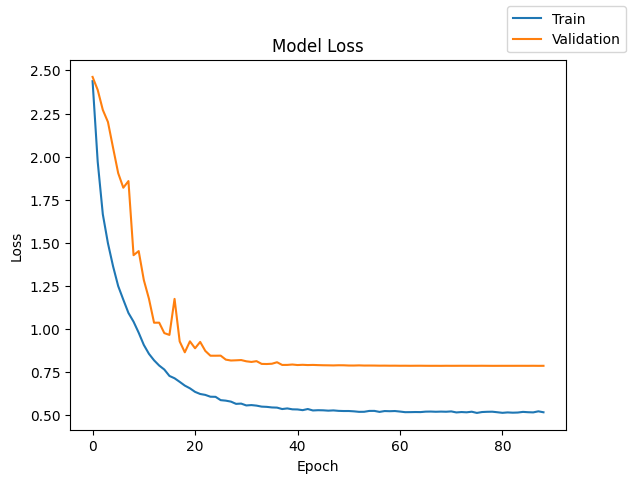

In [53]:
plot(history, 'loss')

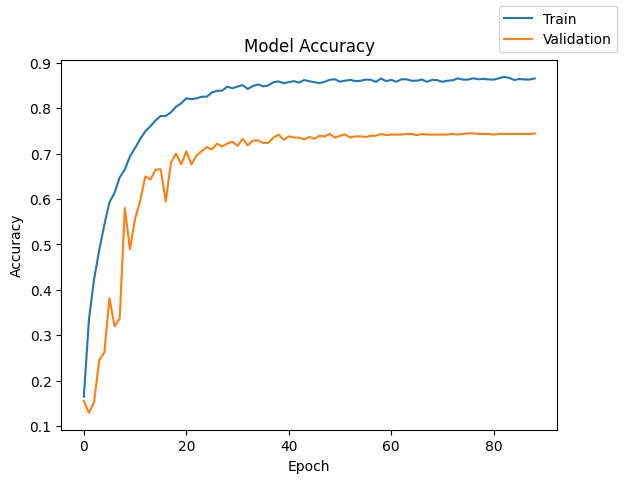

In [54]:
plot(history, 'accuracy')

30/30 [==============================] - 0s 6ms/step


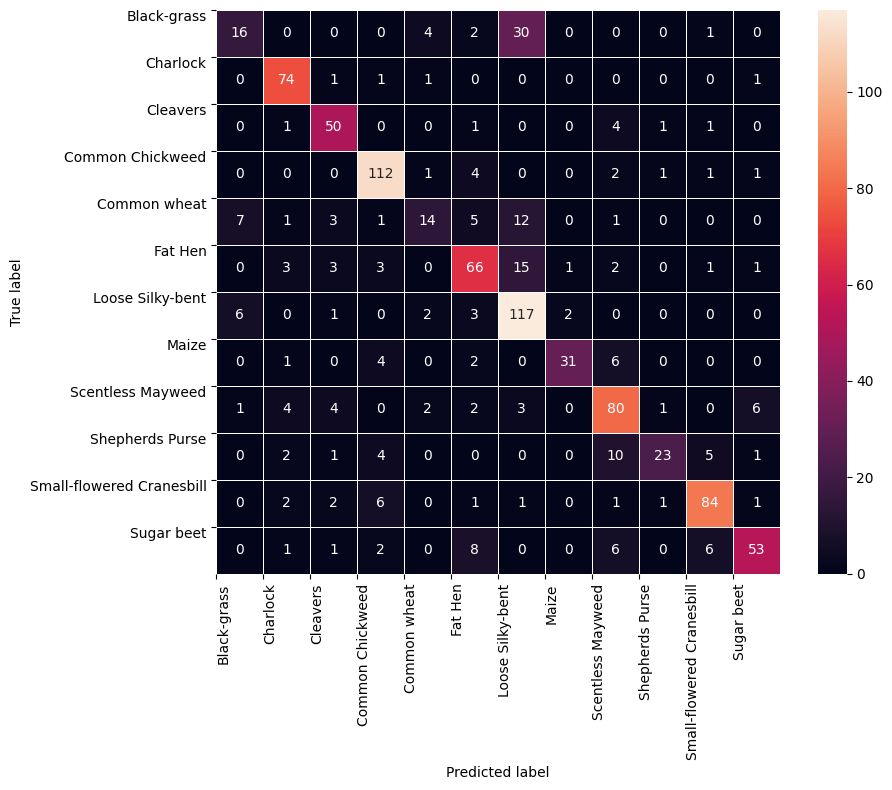

In [55]:
confusion_matrix(cnn_model, X_test, y_test)

In [56]:
del cnn_model

---
- The 1st CNN model is simple with 3 convolution layers, 1 dense layer, and 1 output layer.
- The model is compiled with SGD(learning_rate=1e-3, momentum=0.9)
- The model is fitted with a batch size of 64 and applied with callbacks of early stopping and learning rate schedule.
- The accuracy of the test set is quite good, at 75% with a loss of 0.8.  However, the model is expected to be overfitted. 
---

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

**Note**: Data Augmentation in this project is implemented with references from our [Great Learning Blog](https://www.mygreatlearning.com/blog/understanding-data-augmentation/ 'Source')

---
- The 2nd model replicates the VGG16 model with 5 blocks, 2 custom dense layers, and 1 output layer of 12 classes. 
- Keras tuner is used to apply RandomSearch for Hyper Parameters.
- BatchNormalization is placed before the activation function, and dropout is placed before 
- The model will be fitted again with data augmentation for better performance. 
---

#### <font color='blue'> Data Augmentation</font>

In [57]:
def display_images_generator(data):
    rows=1
    cols=4 
    classes = cat_labels
    fig = plt.figure(figsize=(10, 8))  
    for i in range(rows):
        for j in range(cols):
            for X_batch, y_batch in data:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1) 
                ax.imshow(X_batch[0], cmap=plt.get_cmap('gray'));
                #ax.set_title(classes[y_batch[0]])
                ax.set_title(classes[y_batch[0].astype(int)])
                break
    plt.show;

In [58]:
# Some basic data augmentation techniques
datagen = ImageDataGenerator(rotation_range=20, # Random Rotation                             
                             shear_range=0.1, # Random Shearing
                             width_shift_range=0.1, height_shift_range=0.1, # Random Shifts
                             horizontal_flip=True, vertical_flip=False,   # Horizonal & Vertical Flips
                             # zoom_range=0.1, # Random Zoom
                             fill_mode='nearest')
train_generator = datagen.flow(X_train, y_train, batch_size=64,seed=42)


In [59]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow(X_test, y_test, batch_size=64,seed=42)


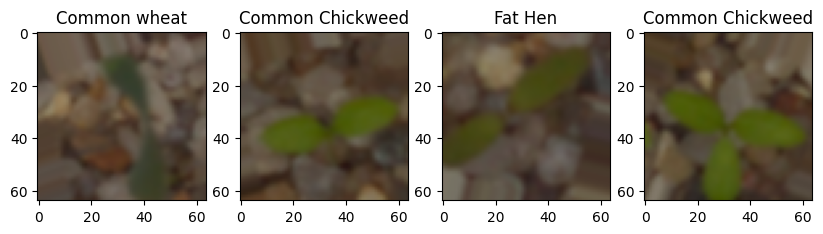

In [60]:
display_images_generator(train_generator)

In [61]:
testX, testY = next(test_generator)

#### <font color='blue'> Custom Model / HyperTuning / 2nd Model</font>

In [62]:
reset_session()

In [63]:
def create_HPmodel(hp):
    
    model = Sequential()

    model.add(keras.layers.Input(shape=input_shape))

    # Hyper Parameter Dropout [0.2, 0.3, 0.5]
    hp_dropout = hp.Choice('dropout', values=[0.3])    
              
    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))   
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))   
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))

    # Block 4
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))   
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))   
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))    
    
    # Block 5
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))  
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))   
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))
    
    # Block 6
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))  
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))  
    model.add(Dropout(hp_dropout))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))    
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(hp_dropout))

    # Hyper Parameter Dense Layers [128, 256]
    hp_layer1 = hp.Choice('units_1', [128])
    hp_layer2 = hp.Choice('units_2', [256])

    # Flatten output
    model.add(Flatten())
    
    # Adding a dense output layer
    model.add(Dense(hp_layer1))
    model.add(BatchNormalization()) 
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    model.add(Dense(hp_layer2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(12, activation='softmax'))

    # # Hyper Parameter Learning Rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=hp_lr), metrics=['accuracy'])
    
    return model   

In [64]:
tuner = RandomSearch(create_HPmodel, objective='val_accuracy', max_trials=1, executions_per_trial=1, overwrite=True, directory='dir', project_name='CV')

In [65]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=30, start_from_epoch=0)

In [66]:
tuner.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[reduce_lr, custom_early_stopping])

Trial 1 Complete [00h 13m 30s]
val_accuracy: 0.86710524559021

Best val_accuracy So Far: 0.86710524559021
Total elapsed time: 00h 13m 30s
INFO:tensorflow:Oracle triggered exit


In [67]:
tuner.results_summary()

Results summary
Results in dir\CV
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
dropout: 0.3
units_1: 128
units_2: 256
learning_rate: 0.001
Score: 0.86710524559021


In [68]:
best_hps = tuner.get_best_hyperparameters()[0]
#best_model = tuner1.hypermodel.build(best_hps)
best_model = tuner.get_best_models()[0]

In [69]:
best_hps.values
#best_model.summary()

{'dropout': 0.3, 'units_1': 128, 'units_2': 256, 'learning_rate': 0.001}

In [70]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=30, start_from_epoch=0)
history = best_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), \
                          shuffle=True,  verbose=1, callbacks=[reduce_lr, custom_early_stopping])

Epoch 1/100
48/48 [==============================] - 8s 165ms/step - loss: 0.2507 - accuracy: 0.9151 - val_loss: 0.5933 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 2/100
48/48 [==============================] - 8s 165ms/step - loss: 0.3172 - accuracy: 0.9000 - val_loss: 1.0019 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 3/100
48/48 [==============================] - 8s 162ms/step - loss: 0.2671 - accuracy: 0.9145 - val_loss: 0.8747 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/100
48/48 [==============================] - 8s 162ms/step - loss: 0.2912 - accuracy: 0.9066 - val_loss: 0.8717 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 5/100
48/48 [==============================] - 8s 162ms/step - loss: 0.2642 - accuracy: 0.9187 - val_loss: 1.2010 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 6/100
48/48 [==============================] - 8s 167ms/step - loss: 0.3036 - accuracy: 0.9049 - val_loss: 1.3655 - val_accuracy: 0.6013 - lr: 0.0010
Epoch 7/100
48/48 [==============================] - 8s 164ms/st

In [71]:
best_model.evaluate(X_test, y_test)

30/30 [==============================] - 1s 41ms/step - loss: 0.9208 - accuracy: 0.8084


[0.9208351969718933, 0.8084210753440857]

In [72]:
best_model.save('Models/Best_model.keras')

---
- The RandomSearch gives a result for dropout of 0.3, the first dense layer of 128, followed by 256 neurons.
- The accuracy of the test set is at 86%, with a loss of 0.69. 
---

#### <font color='blue'> Training with Data Augmentation Generator</font>

In [73]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=30, start_from_epoch=0)

In [74]:
history = best_model.fit(train_generator,steps_per_epoch=(len(X_train))//64, epochs=100, 
                              validation_data=(testX, testY), callbacks=[reduce_lr, custom_early_stopping], verbose=1)  

Epoch 1/100
47/47 [==============================] - 9s 191ms/step - loss: 0.4403 - accuracy: 0.8817 - val_loss: 14.6180 - val_accuracy: 0.1406 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 9s 184ms/step - loss: 0.3697 - accuracy: 0.8901 - val_loss: 1.9648 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 9s 188ms/step - loss: 0.3114 - accuracy: 0.9049 - val_loss: 0.7591 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 9s 187ms/step - loss: 0.2738 - accuracy: 0.9183 - val_loss: 0.9193 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 9s 191ms/step - loss: 0.2556 - accuracy: 0.9197 - val_loss: 1.5241 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 9s 193ms/step - loss: 0.2167 - accuracy: 0.9315 - val_loss: 0.4874 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 9s 191ms/s

In [75]:
best_model.evaluate(test_generator)

15/15 [==============================] - 1s 63ms/step - loss: 1.6697 - accuracy: 0.6337


[1.6696659326553345, 0.6336842179298401]

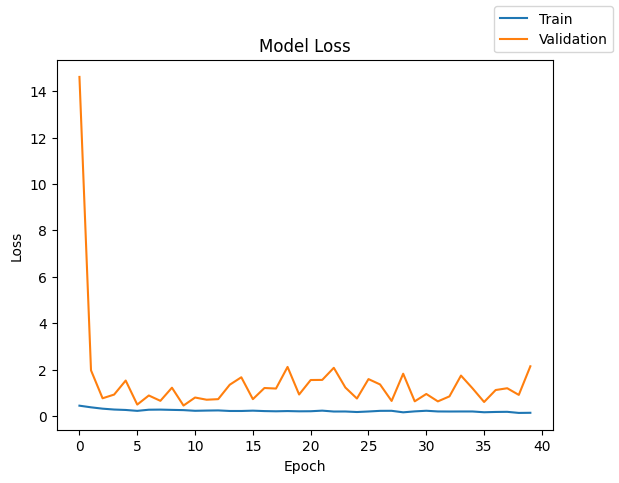

In [76]:
plot(history, 'loss')

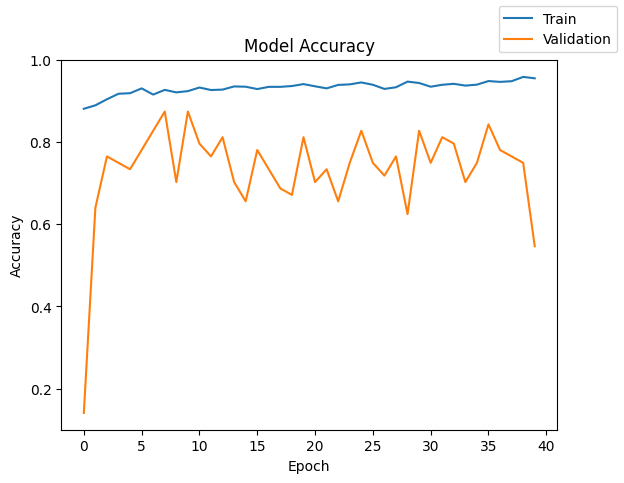

In [77]:
plot(history, 'accuracy')

2/2 [==============================] - 0s 29ms/step


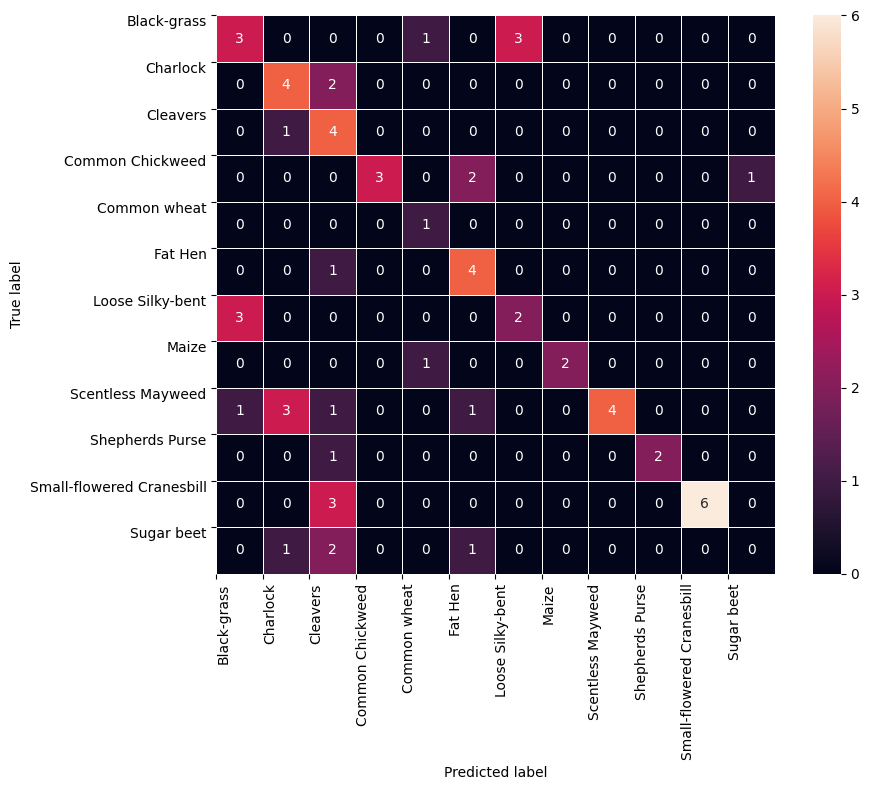

In [78]:
confusion_matrix(best_model,testX, testY)

In [79]:
best_model.save('Models/best_model1.keras')

---
- Data augmentation helps the model generalize more and achieve a test accuracy of 88%.
---

#### <font color='blue'> Training with Data Segmentation</font>

In [80]:
train_generator = datagen.flow(X_seg_train, y_seg_train, batch_size=64,seed=42)
test_generator = test_datagen.flow(X_seg_test, y_seg_test, batch_size=64,seed=42)

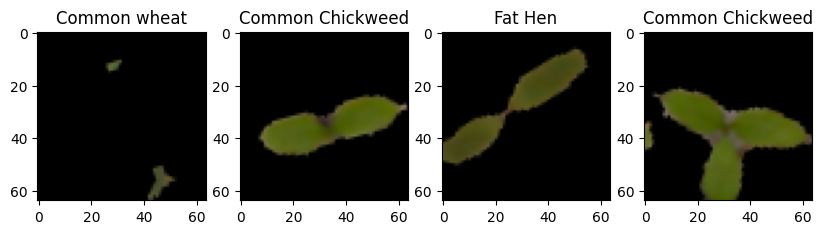

In [81]:
display_images_generator(train_generator)

In [82]:
testX, testY = next(test_generator)

In [83]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=30, start_from_epoch=0)

In [84]:
history = best_model.fit(train_generator,steps_per_epoch=(len(X_train))//64, epochs=100, 
                              validation_data=(testX, testY), callbacks=[reduce_lr, custom_early_stopping], verbose=1)  

Epoch 1/100
47/47 [==============================] - 10s 206ms/step - loss: 0.9050 - accuracy: 0.7540 - val_loss: 5.0923 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 9s 189ms/step - loss: 0.5156 - accuracy: 0.8269 - val_loss: 0.8453 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 9s 185ms/step - loss: 0.4235 - accuracy: 0.8542 - val_loss: 1.0949 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 9s 190ms/step - loss: 0.4262 - accuracy: 0.8495 - val_loss: 1.0198 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 9s 186ms/step - loss: 0.3922 - accuracy: 0.8558 - val_loss: 0.5033 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 9s 191ms/step - loss: 0.3611 - accuracy: 0.8700 - val_loss: 0.6799 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 9s 185ms/s

In [85]:
best_model.evaluate(test_generator)

15/15 [==============================] - 2s 70ms/step - loss: 0.4774 - accuracy: 0.8621


[0.47742247581481934, 0.8621052503585815]

In [86]:
y_true = []
y_pred = []

for batch_x, batch_y in test_generator:
    batch_pred = best_model.predict(batch_x, verbose=0)
    y_true.extend(batch_y)
    y_pred.extend(np.argmax(batch_pred, axis=1)) 
    break
print(classification_report(y_true, y_pred, target_names=cat_labels)) # class_indices.keys()    

                           precision    recall  f1-score   support

              Black-grass       0.25      0.25      0.25         4
                 Charlock       0.80      1.00      0.89         4
                 Cleavers       1.00      0.75      0.86         4
         Common Chickweed       1.00      0.70      0.82        10
             Common wheat       0.75      0.38      0.50         8
                  Fat Hen       0.82      1.00      0.90         9
         Loose Silky-bent       0.45      0.83      0.59         6
                    Maize       1.00      0.75      0.86         4
        Scentless Mayweed       0.67      1.00      0.80         4
          Shepherds Purse       0.50      0.50      0.50         2
Small-flowered Cranesbill       1.00      0.83      0.91         6
               Sugar beet       1.00      1.00      1.00         3

                 accuracy                           0.75        64
                macro avg       0.77      0.75      0.74    

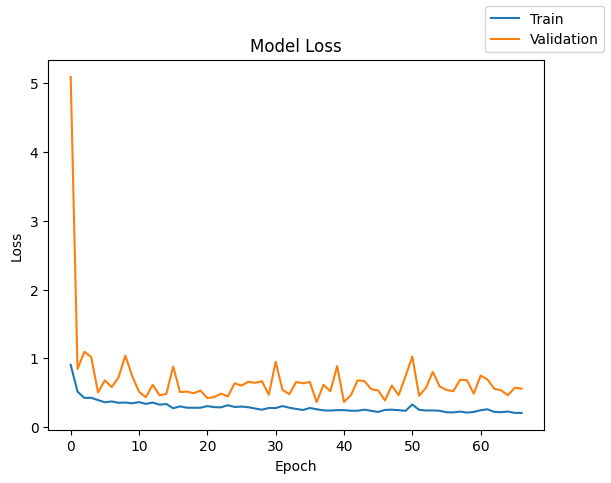

In [87]:
plot(history, 'loss')

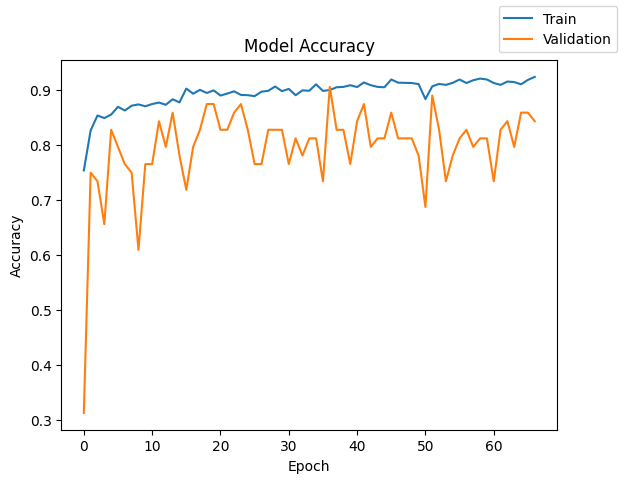

In [88]:
plot(history, 'accuracy')

2/2 [==============================] - 0s 29ms/step


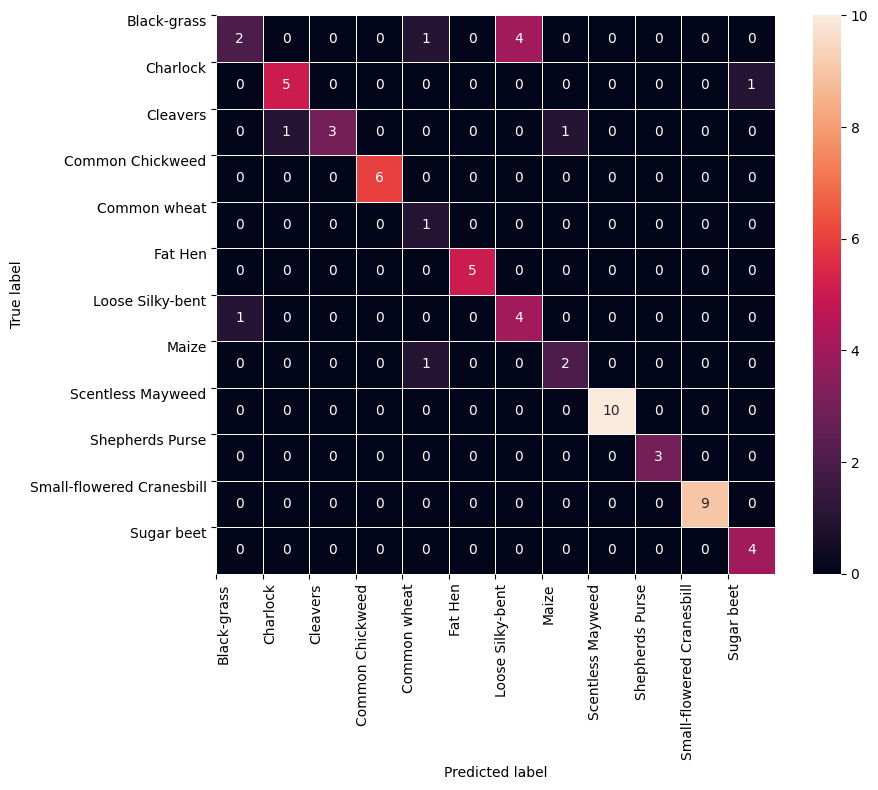

In [89]:
confusion_matrix(best_model,testX, testY)

In [90]:
best_model.save('Models/best_model2.keras')

In [91]:
#del best_model
#del history
#del rgb_image
#del segmented_image

#### <font color='blue'> Transfer Learning VGG16 (3rd Model)</font>

#### 1. Training with Images from Archive Directory
Download links from Aarhus University [here](https://vision.eng.au.dk/plant-seedlings-dataset/)

In [92]:
batch_size = 64
img_height = 64
img_width = 64

In [93]:
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255, 
                             rotation_range=20, # Random Rotation                             
                             shear_range=0.1, # Random Shearing
                             width_shift_range=0.1, height_shift_range=0.1, # Random Shifts
                             horizontal_flip=True, vertical_flip=False,   # Horizonal & Vertical Flips
                             # zoom_range=0.1, # Random Zoom
                             fill_mode='nearest')
train_generator = datagen.flow_from_directory(
    directory='archive',
    subset='training', 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True,
    seed=42)    

Found 4437 images belonging to 12 classes.


In [94]:
test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='archive',
    subset='validation', 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False,
    seed=42) 

Found 1102 images belonging to 12 classes.


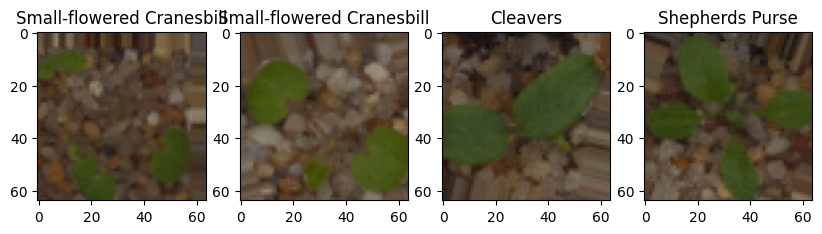

In [95]:
display_images_generator(train_generator)

In [96]:
#Create VGG16 base model
base_model = VGG16(weights='imagenet', include_top = False, input_shape = input_shape)
base_model.trainable = False

In [97]:
def create_VGG_model():   
    model = Sequential()
    # Adding the convolutional part of the VGG16 model 
    model.add(base_model)
    # Flattening the output of the VGG16 model 
    model.add(Flatten())
    # Adding a dense output layer
    model.add(Dense(128))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(BatchNormalization())    
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))

    return model

In [98]:
#Create non-trainable VGG Model
VGG_model = create_VGG_model()
VGG_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 128)               0         
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                      

In [99]:
# Stop and Resume training models
checkpoint_filepath = 'Models/VGG_model_checkpoint.weights.h5'
VGG_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',  
    mode='min'  
)

In [100]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=50, start_from_epoch=0)

In [101]:
VGG_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [102]:
history = VGG_model.fit(train_generator, validation_data=test_generator, epochs=250,  callbacks=[custom_early_stopping, lr_scheduler, VGG_model_checkpoint_callback])

Epoch 1/250
70/70 [==============================] - 143s 2s/step - loss: 2.0900 - accuracy: 0.3007 - val_loss: 1.9655 - val_accuracy: 0.3603 - lr: 0.0010
Epoch 2/250
70/70 [==============================] - 104s 1s/step - loss: 1.6326 - accuracy: 0.4302 - val_loss: 1.6367 - val_accuracy: 0.4401 - lr: 0.0010
Epoch 3/250
70/70 [==============================] - 71s 1s/step - loss: 1.4546 - accuracy: 0.4866 - val_loss: 1.5040 - val_accuracy: 0.4574 - lr: 0.0010
Epoch 4/250
70/70 [==============================] - 41s 589ms/step - loss: 1.3552 - accuracy: 0.5186 - val_loss: 1.3928 - val_accuracy: 0.5181 - lr: 0.0010
Epoch 5/250
70/70 [==============================] - 49s 695ms/step - loss: 1.2860 - accuracy: 0.5416 - val_loss: 1.4756 - val_accuracy: 0.4791 - lr: 0.0010
Epoch 6/250
70/70 [==============================] - 41s 584ms/step - loss: 1.2135 - accuracy: 0.5639 - val_loss: 1.3346 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 7/250
70/70 [==============================] - 53s 759ms/st

In [103]:
# Evaluating on the Test set
VGG_model.evaluate(test_generator)

18/18 [==============================] - 7s 325ms/step - loss: 1.0470 - accuracy: 0.6343


[1.0470420122146606, 0.6343012452125549]

In [104]:
VGG_model.save('Models/VGG_model.keras')

---
- VGG16 Transfer Learning Model only has an accuracy score on the test set of 66%.
- The accuracy score is stuck at around 66% for many epochs.
---

#### <font color='blue'> VGG16 Transfer Learning Model Fine-tuning with segmented image dataset from directory</font>

#### Training with Images from Segmented Directory
Download links from Aarhus University [here](https://vision.eng.au.dk/plant-seedlings-dataset/)

In [105]:
train_generator = datagen.flow_from_directory(
    directory='Segmented', 
    subset='training', 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True,
    seed=42)    

test_generator = test_datagen.flow_from_directory(
    directory='Segmented',   
    subset='validation', 
    target_size=(img_height, img_width),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False,
    seed=42) 

Found 4533 images belonging to 12 classes.
Found 1126 images belonging to 12 classes.


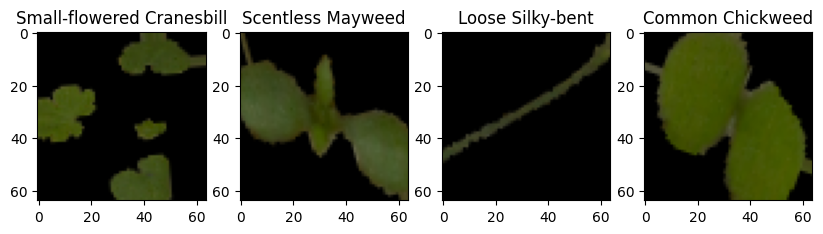

In [106]:
display_images_generator(train_generator)

In [107]:
# Re-training VGG16 model with end to end trainable parameters
base_model.trainable = True

In [108]:
# Stop and Resume training models
checkpoint_filepath2 = 'Models/VGG_model2_checkpoint.weights.h5'
VGG_model2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',  
    mode='min'  
)

In [109]:
VGG_model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [110]:
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=40, start_from_epoch=0)

In [111]:
history = VGG_model.fit(train_generator, validation_data=test_generator, epochs=250,  callbacks=[custom_early_stopping, lr_scheduler, VGG_model2_checkpoint_callback])

Epoch 1/250
71/71 [==============================] - 101s 1s/step - loss: 1.3563 - accuracy: 0.5621 - val_loss: 1.5385 - val_accuracy: 0.5613 - lr: 1.0000e-05
Epoch 2/250
71/71 [==============================] - 25s 343ms/step - loss: 0.8000 - accuracy: 0.7117 - val_loss: 1.1264 - val_accuracy: 0.6599 - lr: 1.0000e-05
Epoch 3/250
71/71 [==============================] - 25s 349ms/step - loss: 0.6544 - accuracy: 0.7750 - val_loss: 0.9352 - val_accuracy: 0.7274 - lr: 1.0000e-05
Epoch 4/250
71/71 [==============================] - 25s 349ms/step - loss: 0.5669 - accuracy: 0.8085 - val_loss: 0.8922 - val_accuracy: 0.7362 - lr: 1.0000e-05
Epoch 5/250
71/71 [==============================] - 24s 339ms/step - loss: 0.5023 - accuracy: 0.8323 - val_loss: 0.7500 - val_accuracy: 0.7629 - lr: 1.0000e-05
Epoch 6/250
71/71 [==============================] - 25s 347ms/step - loss: 0.4608 - accuracy: 0.8416 - val_loss: 0.6950 - val_accuracy: 0.7762 - lr: 1.0000e-05
Epoch 7/250
71/71 [=================

In [112]:
VGG_model.evaluate(test_generator)

18/18 [==============================] - 4s 207ms/step - loss: 0.4022 - accuracy: 0.8588


[0.40220698714256287, 0.8587921857833862]

In [113]:
y_pred = VGG_model.predict_generator(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.76      0.57        66
           1       0.92      0.97      0.94        90
           2       0.92      0.83      0.87        69
           3       0.90      0.99      0.94       143
           4       0.82      0.71      0.76        51
           5       0.95      0.88      0.91       108
           6       0.87      0.67      0.76       163
           7       0.73      1.00      0.85        52
           8       0.93      0.85      0.89       121
           9       0.91      0.73      0.81        55
          10       0.96      0.99      0.97       116
          11       0.93      0.88      0.91        92

    accuracy                           0.86      1126
   macro avg       0.86      0.85      0.85      1126
weighted avg       0.88      0.86      0.86      1126



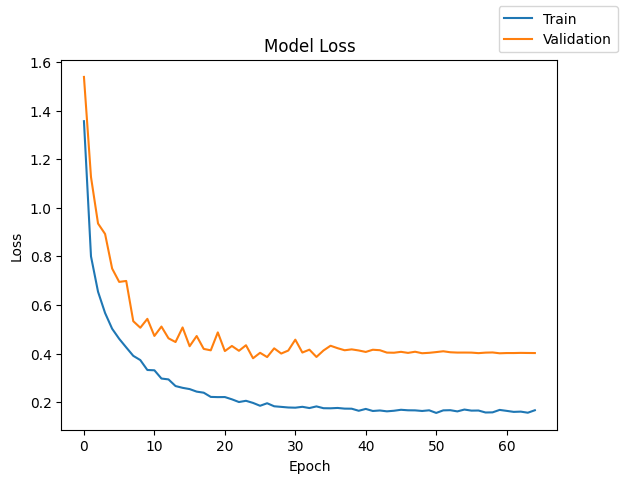

In [114]:
plot(history, 'loss')

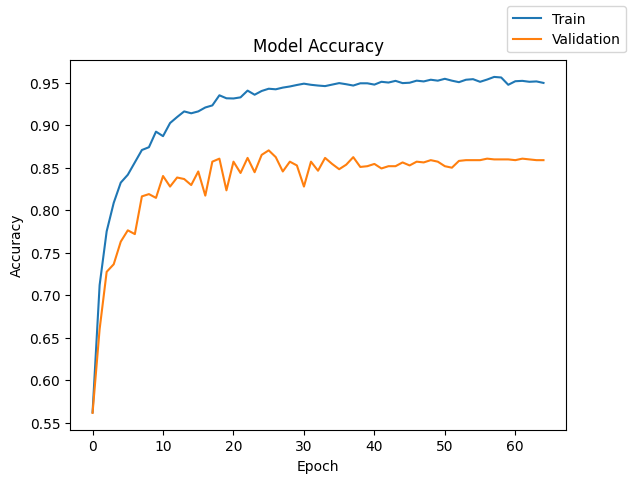

In [115]:
plot(history, 'accuracy')

18/18 [==============================] - 4s 198ms/step


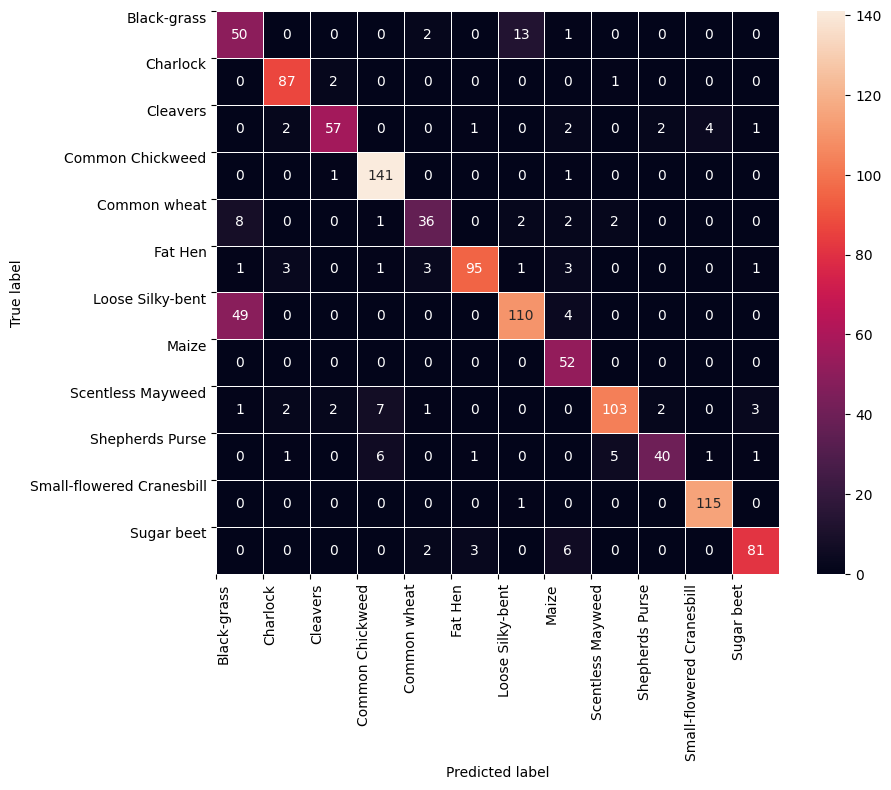

In [116]:
# plot confusion matrix VGG_model
confusion_matrix(VGG_model, test_generator, test_generator.labels)

---
- For VGG16 Transfer Learning Model fine-tuning, the 'trainable' parameter is set to True so we can retrain the whole model end to end.  
- The accuracy score is 86% with the least loss of 0.40.
- We can see that the model still mis-classifies 13 Black Grass as Loose Silky-bent and 49 Loose Silky-bent as Black Grass.
- The results are slightly different every time the model is re-trained. 
---

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

In [117]:
#test_model = keras.models.load_model('Models/VGG_model1.keras')
#test_model.evaluate(test_generator)

In [118]:
final_model = best_model

### Visualizing the prediction

#### <font color='blue'> Predictions on ImagesFromTheWild dataset</font>
Download links from Aarhus University [here](https://vision.eng.au.dk/plant-seedlings-dataset/)

In [165]:
# Function to pre-process test data
def myFunc(pil_image):

    pil_image = cv2.resize(pil_image, (64, 64), interpolation=cv2.INTER_LINEAR)
    pil_image = cv2.cvtColor(pil_image, cv2.COLOR_BGR2RGB) 
    pil_image = segment(pil_image)
    pil_image = np.expand_dims(pil_image, axis=0)
    pil_image = pil_image.astype('float32')/(255)
    
    return pil_image

In [166]:
# Loading test images with Generator
wild_datagen = ImageDataGenerator(rescale=1./255) # preprocessing_function only works in RGB/BGR

wild_generator = wild_datagen.flow_from_directory(
    directory='jpeg',
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=8,
    class_mode="sparse",
    shuffle=False,
    seed=42)                                                  


Found 96 images belonging to 12 classes.


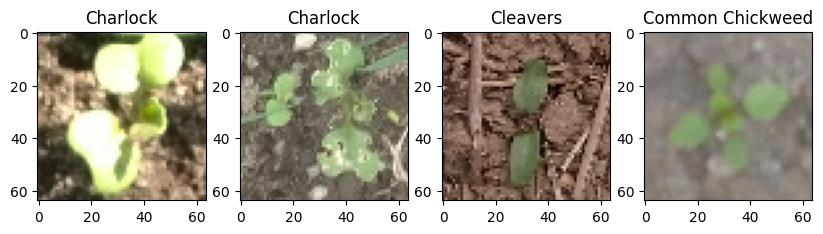

In [167]:
display_images_generator(wild_generator)

In [124]:
# Make Predictions from Wild Image Dataset

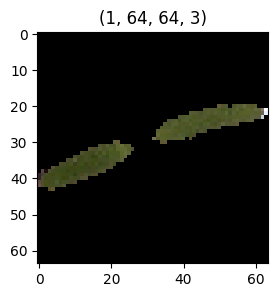

In [141]:
# 1st test image from import dataset
img0 = myFunc(cv2.imread('images/77FatHen.png'))

fig = plt.figure(figsize=(3, 3))
plt.imshow(img0[0], cmap=plt.get_cmap('gray'));
plt.title(img0.shape);

In [142]:
# Correct Prediction
prediction0 = final_model.predict(img0)
cat_labels[prediction0.argmax() ]

1/1 [==============================] - 0s 112ms/step


'Fat Hen'

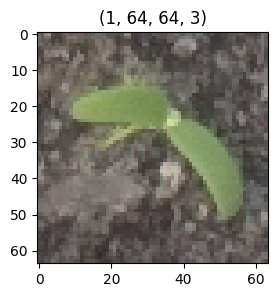

In [151]:
# 2nd test image from ImagesFromTheWild dataset
img2 = cv2.imread('images/Fat Hen.tiff')
img2 = cv2.resize(img2, (64, 64), interpolation=cv2.INTER_LINEAR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
img2 = np.expand_dims(img2, axis=0)
img2 = img4.astype('float32')/(255)

fig = plt.figure(figsize=(3, 3))
plt.imshow(img2[0], cmap=plt.get_cmap('gray'));
plt.title(img2.shape);

In [152]:
# Correct Prediction
prediction2 = final_model.predict(img2)
cat_labels[prediction2.argmax() ]

1/1 [==============================] - 0s 67ms/step


'Fat Hen'

---
- Our model correctly identifies the plant seedling Fat Hen. However, the model fails to classify the Cleavers plant from a wild image as Shepherds Purse.
- Maybe more image processing should be done on the background or contrast to improve the predictions. 
---

### Summary:
- All required libraries are imported in addition to the OpenCV library for image processing.
- I train and evaluate 3 models, a simple CNN model, a custom VGG model, and a VGG16 transfer learning model
The first model has 73% accuracy. The second model has 85% accuracy with hypertuning and data augmentation.
The third model VGG16 Transfer Learning Model has the highest accuracy of 87%. 
- In conclusion, Transfer Learning helps with training and computing resources.  Once the model is retrained end to end with new weights, BatchNormalization, and Dropout, we can achieve a higher accuracy score. 

## Actionable Insights and Business Recommendations

*Our fine-tuning VGG16 transfer learning model can help the Agriculture field correctly classify the 12-species plant seedlings by their young bird-eye view images.  With the improvement of our AI model, the need for manual labor will be reduced and the innovation of Research will be expanded greatly. Therefore, the more wild dataset we can obtain, the better we can train our model with. 

_____

# Introduction to Computer Vision: Plant Seedlings Classification

In [137]:
# Another option to load images with TensorFlow (better prediction results! But not sure Why?)
# train_ds = tf.keras.utils.image_dataset_from_directory(
#       "archive",
#       validation_split=0.2,
#       subset='training',
#       seed=42,
#       image_size=(img_height, img_width),
#       batch_size=batch_size)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#       "archive",
#       validation_split=0.2,
#       subset='validation',
#       image_size=(img_height, img_width),
#       batch_size=batch_size)

# class_names = train_ds.class_names

# val_size = int(0.5* val_ds.cardinality().numpy())
# val_set = val_ds.take(val_size)
# test_set = val_ds.skip(val_size)

# print(val_ds.cardinality().numpy())
# print(val_set.cardinality().numpy())
# print(test_set.cardinality().numpy())

# class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(12):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# normalization_layer = tf.keras.layers.Rescaling(1./255)

# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# normalized_val_ds = val_set.map(lambda x, y: (normalization_layer(x), y))
# normalized_test_ds= test_set.map(lambda x, y: (normalization_layer(x), y)) 

# AUTOTUNE = tf.data.AUTOTUNE
# normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# normalized_test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)
